In [21]:
import pandas as pd
from typing import List
import glob
import pathlib
import re
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

#matplotlib.use('TkAgg')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


MARKERS = ['v','X','>', 'o','s','p', 'P', '*', 'D', 'd', '<', 'H', 'h', '3', '1', '2']

# get latex files
latex_files = []
folders = [33, 66, "mid", "high", "low"]
for folder in folders:
    latex_files.extend(glob.glob(f'/Users/kimathikaai/scratch/saved/domainbed_results/{folder}/*.tex', recursive=True))
    
print("Number of latex Files: ", len(latex_files))
assert len(latex_files) == len(folders) * 6 * 6

# convert latex documents to a pandas dataframe
from results import scrape_latex
data = []
# scrape each latex file
for file in latex_files:
    #print('[info] processing: ', file)
    data.extend(scrape_latex(file))

# convert to pandas data frame
df = pd.DataFrame.from_dict(data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of latex Files:  180


# Ablations
- Imposing fairnes (POXL) increases (nacc,nacc) and (acc,acc) than without (POXL-F) for (PACS, 33, 66)
- (POXL+B) is better than (POXL) for lower overlap (PACS, 33) but not for higher overlap
    - More difficult to impose fairness with less overlapping data
- Including alpha+beta is benefical for (acc, acc, PACS, 33, 66) (POXL-F-A vs POXL-F+B)
    - (nacc, nacc, PACS, 66) alpha+beta is more beneficial
    - (nacc, nacc, PACS, 33) alpha+beta is less beneficial

In [2]:
data = df.loc[(df['evaluation_metric'].isin(['nacc', 'macc']))&(df['selection_metric'].isin(['macc','nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].str.contains('POXL')].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
pd.pivot_table(data=data, values='evaluation_value', index=['selection_metric', 'evaluation_metric','algorithm'], columns=['dataset', 'overlap'], aggfunc=np.mean)

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/569162712.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = df.loc[(df['evaluation_metric'].isin(['nacc', 'macc']))&(df['selection_metric'].isin(['macc','nacc']))&(df['dataset'].isin(['PACS', 'OfficeHome']))&(df['overlap'].isin(['33', '66']))][df['algorithm'].str.contains('POXL')].sort_values(by='algorithm', ascending=True).reset_index(drop=True)


dataset                                      OfficeHome        PACS      
overlap                                              33    66    33    66
selection_metric evaluation_metric algorithm                             
macc             macc              POXL            47.9  53.7  49.0  59.9
                                   POXL+B          47.5  53.9  50.2  58.0
                                   POXL-F          47.6  55.3  48.9  58.3
                                   POXL-F+B        47.3  54.7  49.0  59.1
                                   POXL-F-A        47.6  54.3  48.6  58.9
                 nacc              POXL            40.9  39.8  34.2  14.9
                                   POXL+B          40.3  40.6  35.3  11.6
                                   POXL-F          40.5  40.3  34.2  13.0
                                   POXL-F+B        40.2  39.9  34.1  14.8
                                   POXL-F-A        40.9  39.3  33.7  13.1
nacc             macc              POXL            47.4  52.1  49.1  57.3
                                   POXL+B          46.9  52.6  49.8  57.8
                                   POXL-F          47.8  55.3  47.4  59.4
                                   POXL-F+B        47.5  53.9  49.4  57.4
                                   POXL-F-A        47.9  53.5  49.1  59.0
                 nacc              POXL            40.9  41.3  35.2  20.4
                                   POXL+B          40.3  40.6  35.3  19.1
                                   POXL-F          41.0  41.7  33.2  15.4
                                   POXL-F+B        40.6  40.8  35.3  17.5
                                   POXL-F-A        41.0  39.1  35.4  17.3

# Relationships Between Metrics
- Determine what `selection_metric` is a good indicator for a specific `evaluation_metric`

In [3]:
df.loc[(df['selection_metric'].isin(['nacc', 'acc'])) &(df['evaluation_metric'].isin(['nacc','acc']))
#].groupby(['dataset', 'overlap', 'selection_metric', 'evaluation_metric']).mean(numeric_only=True)
].groupby(['dataset','selection_metric', 'evaluation_metric']).mean(numeric_only=True)

evaluation_value  \
dataset    selection_metric evaluation_metric                     
OfficeHome acc              acc                       50.106250   
                            nacc                      39.321875   
           nacc             acc                       49.756250   
                            nacc                      39.590625   
PACS       acc              acc                       53.100000   
                            nacc                      28.332000   
           nacc             acc                       52.850000   
                            nacc                      30.408000   
VLCS       acc              acc                       47.120690   
                            nacc                      40.027586   
           nacc             acc                       44.748276   
                            nacc                      50.324138   

                                               evaluation_std  
dataset    selection_metric evaluation_metric                  
OfficeHome acc              acc                      0.390625  
                            nacc                     0.459375  
           nacc             acc                      0.403125  
                            nacc                     0.459375  
PACS       acc              acc                      0.584000  
                            nacc                     0.844000  
           nacc             acc                      0.780000  
                            nacc                     1.032000  
VLCS       acc              acc                      0.817241  
                            nacc                     1.320690  
           nacc             acc                      1.337931  
                            nacc                     2.068966

### What is  the AVERAGE performance ACROSS DATASETS for each overlap and metric?

In [4]:
df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/2889167385.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()


evaluation_value  \
overlap selection_metric evaluation_metric algorithm                          
33      acc              acc               ARM                    45.800000   
                                           CAD                    44.433333   
                                           CORAL                  47.466667   
                                           ERM                    46.400000   
                                           Intra                  46.833333   
                                           Intra_XDom             47.500000   
                                           MLDG                   45.733333   
                                           POXL                   46.666667   
                                           POXL+B                 47.300000   
                                           POXL-F                 47.033333   
                                           POXL-F+B               47.900000   
                                           POXL-F-A               47.900000   
                                           SelfReg                46.066667   
                                           Transfer               45.700000   
                                           XDomBatch              46.100000   
                                           XDomBetaMLDG           47.433333   
                                           XDomBetaMLDGV2         46.500000   
                                           XDomMLDG               47.200000   
                                           XMLDG                  47.333333   
                         f1                ARM                    41.266667   
                                           CAD                    39.433333   
                                           CORAL                  42.700000   
                                           ERM                    41.466667   
                                           Intra                  42.133333   
                                           Intra_XDom             41.800000   
                                           MLDG                   41.566667   
                                           POXL                   42.066667   
                                           POXL+B                 42.933333   
                                           POXL-F                 42.933333   
                                           POXL-F+B               43.250000   
                                           POXL-F-A               43.350000   
                                           SelfReg                41.166667   
                                           Transfer               41.133333   
                                           XDomBatch              39.900000   
                                           XDomBetaMLDG           42.466667   
                                           XDomBetaMLDGV2         40.500000   
                                           XDomMLDG               42.600000   
                                           XMLDG                  43.233333   
                         macc              ARM                    47.200000   
                                           CAD                    45.600000   
                                           CORAL                  48.500000   
                                           ERM                    47.800000   
                                           Intra                  48.233333   
                                           Intra_XDom             49.700000   
                                           MLDG                   47.866667   
                                           POXL                   48.066667   
                                           POXL+B                 48.966667   
                                           POXL-F                 48.533333   
                                           POXL-F+B               48.550000   
                              

### What is the performance across dataset, overlap and metric?

In [5]:
df_pivot = df.loc[
    (df['dataset'].isin(['OfficeHome', 'PACS', 'VLCS'])) &
    (df['overlap'].isin(['33', '66'])) &
    (df['evaluation_metric'].isin(['macc', 'nacc'])) &
    (df['selection_metric'].isin(['macc', 'nacc']))
]
pd.pivot(data=df_pivot, values='evaluation_value', index=['selection_metric', 'evaluation_metric','algorithm'], columns=['dataset', 'overlap'])

#.groupby(['dataset','overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean(numeric_only=True)

dataset                                            VLCS  PACS OfficeHome  \
overlap                                              33    33         33   
selection_metric evaluation_metric algorithm                               
macc             macc              ARM             49.3  49.4       45.1   
                                   CAD             46.7  46.2       44.0   
                                   CORAL           47.6  49.3       48.9   
                                   ERM             49.9  49.4       45.3   
                                   Intra           49.0  49.7       48.0   
                                   Intra_XDom       NaN  49.7        NaN   
                                   MLDG            51.0  50.3       44.4   
                                   POXL            51.2  49.0       47.9   
                                   POXL+B          51.6  50.2       47.5   
                                   POXL-F          49.8  48.9       47.6   
                                   POXL-F+B         NaN  49.0       47.3   
                                   POXL-F-A         NaN  48.6       47.6   
                                   SelfReg         48.2  46.0       47.8   
                                   Transfer        50.3  50.7       45.4   
                                   XDomBatch        NaN  48.4        NaN   
                                   XDomBetaMLDG    51.1  48.5       47.9   
                                   XDomBetaMLDGV2   NaN  48.2        NaN   
                                   XDomMLDG        51.7  48.9       47.4   
                                   XMLDG           51.2  50.0       47.7   
                 nacc              ARM             43.8  35.0       38.0   
                                   CAD             44.8  31.1       37.1   
                                   CORAL           43.4  34.3       40.8   
                                   ERM             45.2  34.8       38.8   
                                   Intra           47.0  34.8       40.6   
                                   Intra_XDom       NaN  34.9        NaN   
                                   MLDG            49.8  36.6       38.1   
                                   POXL            47.3  34.2       40.9   
                                   POXL+B          47.9  35.3       40.3   
                                   POXL-F          45.9  34.2       40.5   
                                   POXL-F+B         NaN  34.1       40.2   
                                   POXL-F-A         NaN  33.7       40.9   
                                   SelfReg         43.6  30.4       39.9   
                                   Transfer        46.3  37.8       38.8   
                                   XDomBatch        NaN  34.0        NaN   
                                   XDomBetaMLDG    46.8  33.9       40.5   
                                   XDomBetaMLDGV2   NaN  33.2        NaN   
                                   XDomMLDG        46.5  34.2       40.3   
                                   XMLDG           47.2  35.1       40.7   
nacc             macc              ARM             48.6  49.6       45.5   
                                   CAD             45.1  47.2       43.8   
                                   CORAL           45.9  48.1       48.7   
                                   ERM             50.9  49.6       45.1   
                                   Intra           47.7  49.5       47.3   
                                   Intra_XDom       NaN  51.1        NaN   
                                   MLDG            49.4  50.7       44.5   
                                   POXL            50.1  49.1       47.4   
                                   POXL+B          49.3  49.8       46.9   
                                   POXL-F          49.6  47.4       47.8   
                                   POXL-F+B         NaN  49.4       47.5   
                                   POXL-F-A     

### What is the difference between "oacc" and "noacc"?

In [6]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']

# nacc DNE in full overlap and oacc DNE in none overlap
data = df.loc[(
    (df['overlap'] == '33') | (df['overlap'] == '66') | 
    (df['overlap'] == 'mid') | (df['overlap'] == 'low')
)]

cols_a = ['dataset', 'algorithm', 'overlap', 'selection_metric', 'evaluation_value']
df_oacc = data[data['evaluation_metric'] == 'oacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)
df_nacc = data[data['evaluation_metric'] == 'nacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)

assert len(df_nacc) == len(df_oacc)
df_oacc['oacc-nacc'] = df_oacc['evaluation_value'] - df_nacc['evaluation_value']
data = df_oacc[['dataset', 'algorithm', 'overlap', 'selection_metric', 'oacc-nacc']]
a = data.groupby(['dataset', 'overlap', 'selection_metric','algorithm', 'oacc-nacc']).mean()

### What is the top performing algorithm for each dataset, overlap, and metric?
- For OfficeHome (33&66) the non-overlapping accuracy is highest for (XDom, Intra and SupCon approaches) consistently
- In general XDom shines the most with the availability of overlapping classes to benefit the non-overlapping classes (having a memory queue for under represented samples would help)
    - However we can also reduce the scope of the problem by focusing on 50%-75% overlap cases and/or performing random class selection
- (PACS 66) (selec, eval)
    - (acc,acc) XDom, XDomBatch, XDomError
    - (acc,f1) XDom, XDomError, XDomBatch
    - (acc,nacc) Transfer with 0.2% difference from XDomError with 0.7% difference from XDom

In [7]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']
base_group = df.loc[
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'Intra') &
#         (df['algorithm'] != 'SupCon') &
#         (df['algorithm'] != 'Intra_XDom') &
#         ((df['dataset'] == 'PACS') | (df['dataset'] == 'OfficeHome'))  &
#         (df['overlap'] == 66) &
        (df['algorithm'] != 'XDomBatch')
    ].groupby(cols)
base_group.mean().loc[
    base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()
]

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/3777563572.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().loc[
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/3777563572.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()


evaluation_value  \
dataset    overlap selection_metric evaluation_metric algorithm                          
OfficeHome 33      acc              acc               CORAL                       50.1   
                                    f1                CORAL                       46.7   
                                    macc              CORAL                       49.0   
                                    nacc              POXL-F-A                    41.7   
                                    oacc              CORAL                       61.7   
                                    vacc              CORAL                       51.4   
                   f1               acc               CORAL                       50.3   
                                    f1                XMLDG                       46.8   
                                    macc              CORAL                       49.0   
                                    nacc              XMLDG                       41.8   
                                    oacc              CORAL                       62.0   
                                    vacc              CORAL                       51.4   
                   macc             acc               CORAL                       50.2   
                                    f1                CORAL                       46.4   
                                    macc              CORAL                       48.9   
                                    nacc              POXL                        40.9   
                                    oacc              CORAL                       61.7   
                                    vacc              CORAL                       51.3   
                   nacc             acc               CORAL                       49.9   
                                    f1                CORAL                       46.2   
                                    macc              CORAL                       48.7   
                                    nacc              POXL-F                      41.0   
                                    oacc              CORAL                       61.5   
                                    vacc              CORAL                       51.1   
                   oacc             acc               CORAL                       50.1   
                                    f1                CORAL                       46.4   
                                    macc              CORAL                       48.6   
                                    nacc              Intra                       40.7   
                                    oacc              CORAL                       61.8   
                                    vacc              CORAL                       51.1   
                   vacc             acc               CORAL                       50.2   
                                    f1                CORAL                       46.5   
                                    macc              CORAL                       48.9   
                                    nacc              CORAL                       40.8   
                                    oacc              CORAL                       61.9   
                                    vacc              CORAL                       51.3   
           66      acc              acc               POXL-F                      53.7   
                                    f1                POXL-F                      49.9   
                                    macc              CORAL                       55.6   
                                    nacc              POXL-F                      40.8   
                                    oacc              CORAL                       60.7   
                                    vacc              POXL-F                      49.9   
                   f1               acc               POXL-F                      54.0   
                    

In [8]:
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import itertools

def plot_results(df, selec_metric, eval_metric, overlap_list, dataset_list):
    
    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    fig, ax = plt.subplots(
        nrows = len(dataset_list),
        ncols = len(overlap_list),
        figsize=(10,10),
        #figsize=(8,5),
        sharey=False)
    
    if len(dataset_list) == 1:
        ax = [ax]

    for i, dataset in enumerate(dataset_list):
        for j, overlap in enumerate(overlap_list):
            data = df.loc[
                (df['dataset'] == dataset) &
                (df['selection_metric'] == selec_metric) &
                (df['evaluation_metric'] == eval_metric) &
                (df['overlap'] == overlap)
            ].sort_values(by=['algorithm'], ascending=True)
            
            ax[i][j].bar(
                data.algorithm, 
                data.evaluation_value, 
                color=my_cmap(rescale(data.evaluation_value)),
                width=0.6
            )

            #plot_data = df_group.mean()['evaluation_value']
            #max_algo = plot_data.idxmax()
            #print(plot_data)

            #plot_data.plot(ax=ax[i][j], kind="bar")
            ax[i][j].set_title(f"{dataset}-{overlap}")
            #ax[i][j].set_yticks(np.arange(20,60,5))
            ax[i][j].yaxis.set_minor_locator(AutoMinorLocator(2))
            ax[i][j].get_yaxis().set_major_locator(MaxNLocator(integer=True))
            ax[i][j].set_ylim(
                min(data.evaluation_value) - 3,
                max(data.evaluation_value) + 3)
            #ax[i][j].set_ylim(40, 60)
            ax[i][j].grid(axis="y", which="both")
            ax[i][j].tick_params(axis='x', labelrotation=90)
            # ax[i][j].legend()
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    fig.tight_layout(pad=1.0, h_pad=2.0)
    return fig

## Plot baselines performance across different overlaps and datasets
- XDomBeta > XDom for PACS (nacc,nacc) & (acc,acc) & (f1,f1)
- XMLDG > MLDG for OfficeHome 66 across all s=e settings

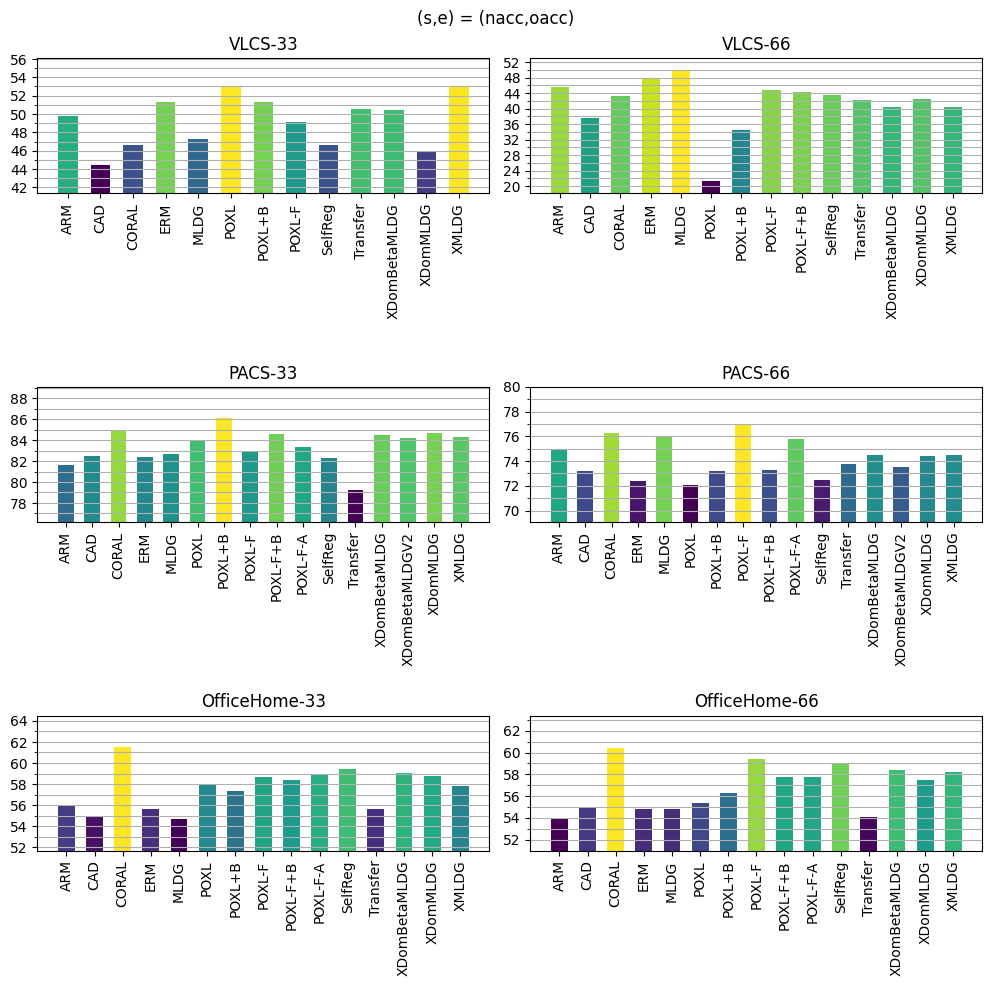

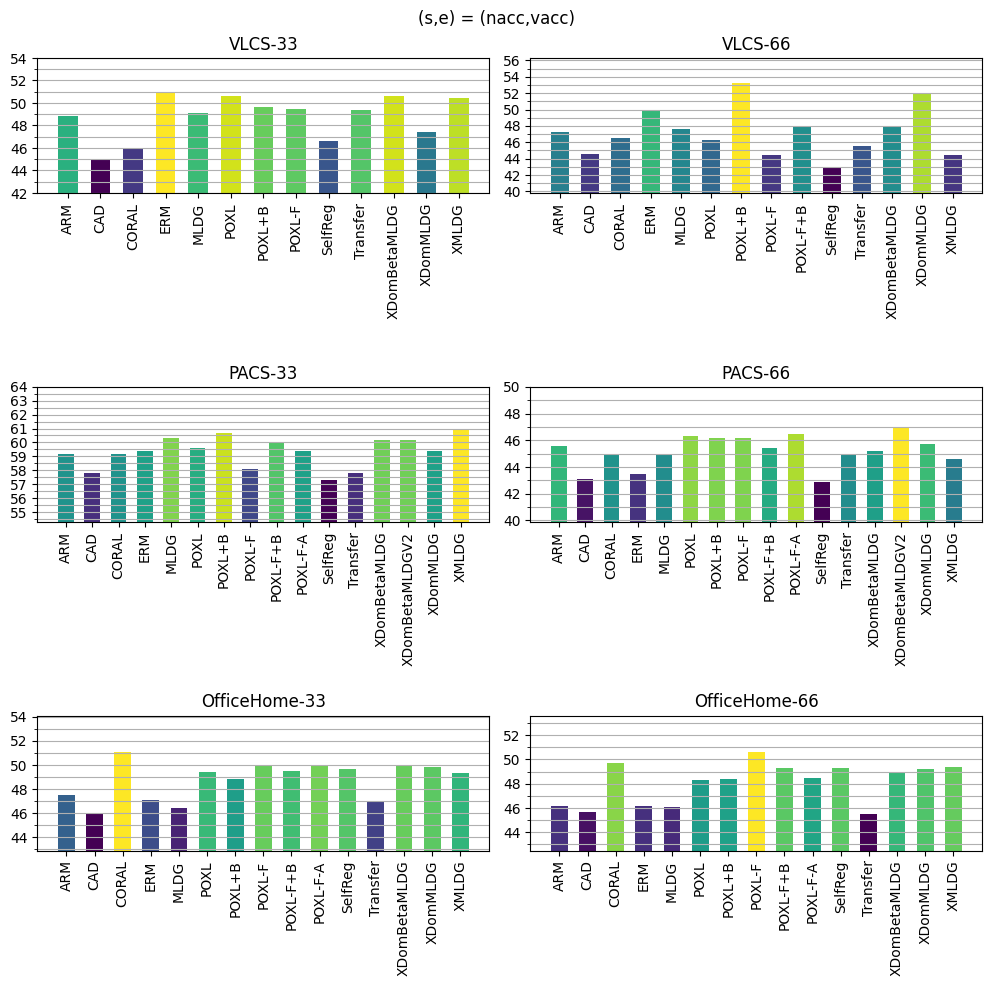

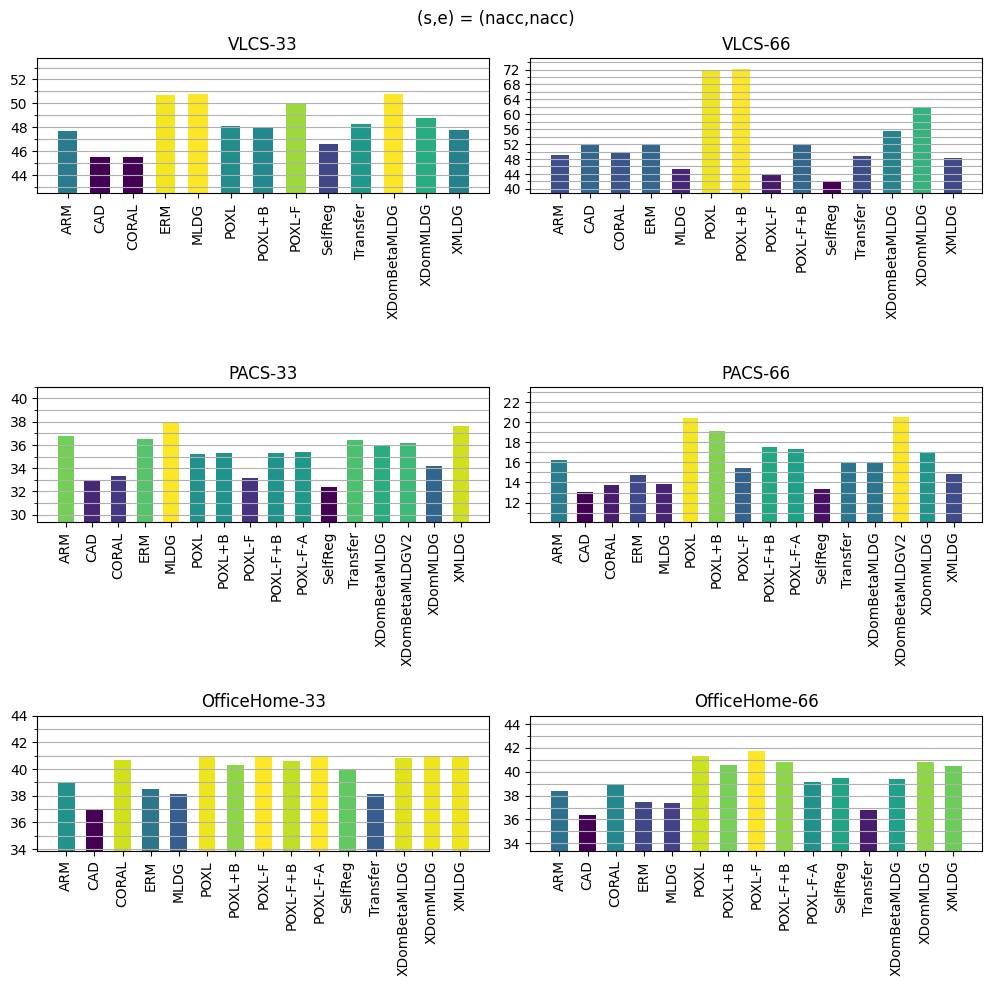

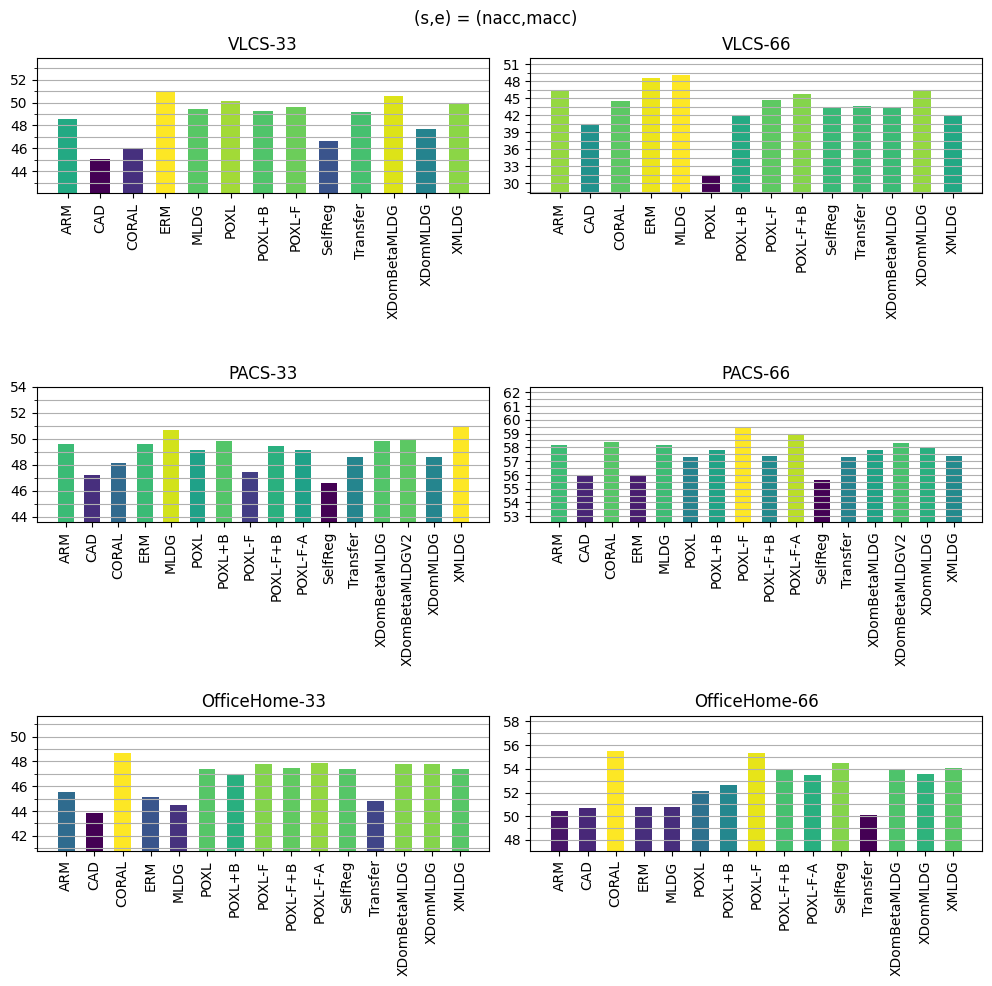

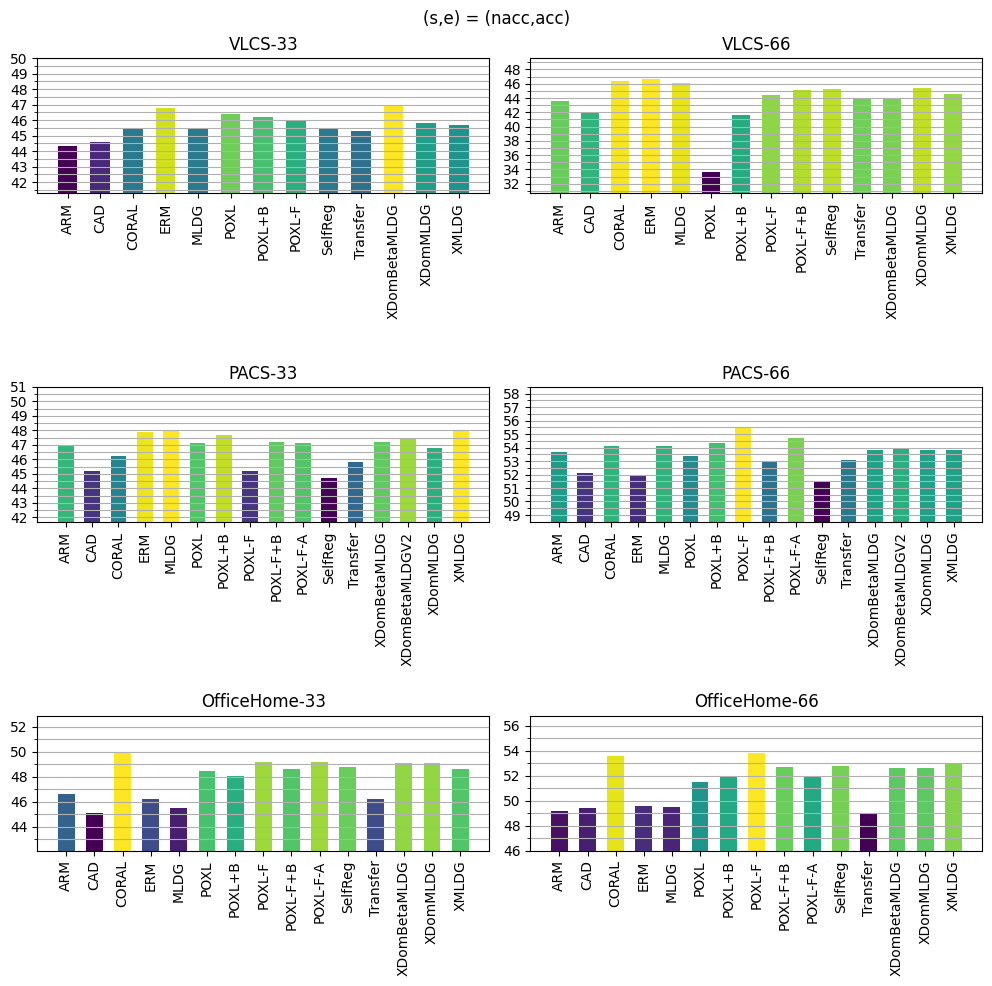

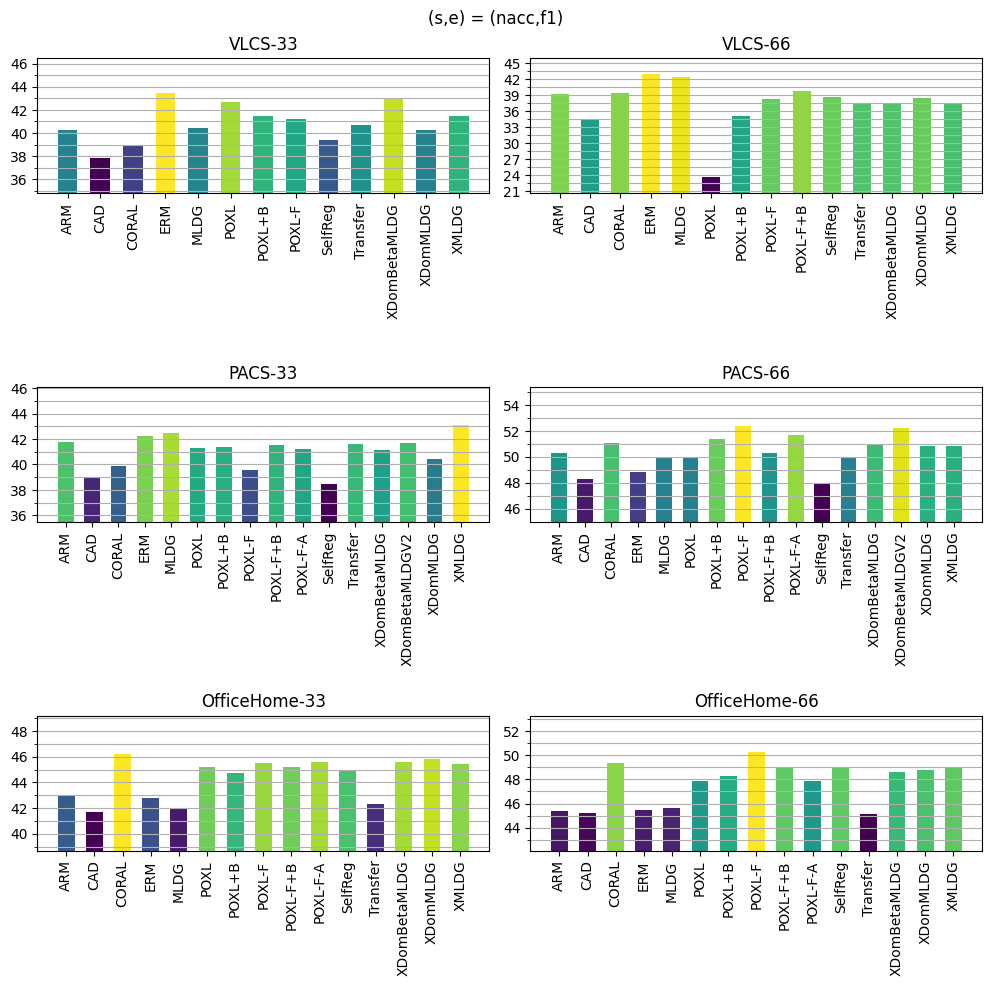

In [9]:
# remove non-baseline
data = df.loc[
    (df['algorithm'] != 'Intra') &
    (df['algorithm'] != 'SupCon') &
    (df['algorithm'] != 'Intra_XDom') &
    (df['algorithm'] != 'XDom') &
    (df['algorithm'] != 'XDomError') &
    (df['algorithm'] != 'XDomBatch') 
]

overlap_list = ['33', '66']
dataset_list = list(df["dataset"].unique())
# dataset_list = ['VLCS']
sl = list(data["selection_metric"].unique())
el = list(data["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    #if e != s: continue
    if s != 'nacc': continue
    #if e not in  ['nacc', 'vacc', 'macc']: continue
    # if e != 'f1' or s != 'f1': continue
    plot_results(data, s, e, overlap_list, dataset_list)

## Plot the relationship between "nacc" and "oacc"
- Could average across: datasets, overlaps, selection_metrics
    - Across datasets would be the most beneficial and easiest to justify
- Purpose of this plot is display the relationship between non-overlapping and overlapping class accuracies for different methods
- With `selec_metric='nacc'` across all datasets (even excluding VLCS anomally) XDom best accuracy and XDomError best non-overlapping accuracy
- Set the ylim and xlim with the zoom in plot to show the performance discrepancy
- Show the accuracy color gradient in the plot
- Use a zoomed in subplot for the results

(nacc, oacc)
(nacc, nacc)
(nacc, acc)
(nacc, vacc)
(nacc, macc)
(nacc, f1)
   marker       algorithm       nacc       oacc        acc       macc  \
0       3           XMLDG  38.333333  61.366667  48.916667  50.300000   
1       h        XDomMLDG  40.566667  60.633333  48.916667  50.333333   
2       H  XDomBetaMLDGV2  28.350000  78.850000  50.750000  54.100000   
3       <    XDomBetaMLDG  39.716667  61.216667  48.950000  50.566667   
4       d        Transfer  37.416667  59.250000  47.200000  48.933333   
5       D         SelfReg  35.633333  60.566667  48.083333  49.000000   
6       *        POXL-F-A  33.200000  68.975000  50.725000  52.375000   
7       P          POXL+B  42.566667  59.783333  48.300000  49.750000   
8       p            POXL  42.900000  57.283333  46.766667  47.883333   
9       s            MLDG  37.216667  60.933333  48.100000  50.450000   
10      o             ERM  38.283333  60.716667  48.183333  50.150000   
11      >           CORAL  36.983333  62.183333  

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/1023628084.py:71: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  s=ax.scatter(
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/1023628084.py:122: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axins.scatter(


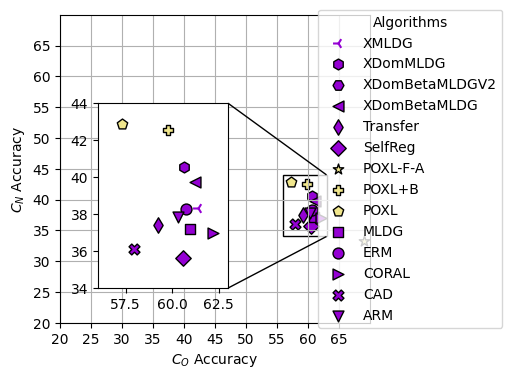

In [13]:
import math
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
color_metric = "av_acc"
x='oacc'
y='nacc'

def get_metric(data, eval_metric, selec_metric='nacc'):
    """Averaging across overlaps and datasets"""
    print(f"({selec_metric}, {eval_metric})")
    data = df.loc[
        #(df['dataset'] != 'VLCS') &
        # (df['dataset'] == 'OfficeHome') &
        (df['selection_metric'] == selec_metric) &  
        (df['evaluation_metric'] == eval_metric) &
        ((df['overlap'] == '33') | (df['overlap'] == '66')) &
        (df['algorithm'] != 'XDomBatch') &
#         (df['algorithm'] != 'POXL') &
        (df['algorithm'] != 'POXL-F+B') &
        (df['algorithm'] != 'POXL-F') &
        (df['algorithm'] != 'SupCon') &
        (df['algorithm'] != 'Intra') &
        (df['algorithm'] != 'Intra_XDom')
    ].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
    
    cols = ['algorithm', 'overlap', 'dataset', 'evaluation_value']
    # print(data.groupby(cols).mean())
    metric_data = data.groupby('algorithm').mean(numeric_only=True).reset_index(names="algorithm")
    #print(metric_data)
    return metric_data


df_oacc = get_metric(df, 'oacc')
df_nacc = get_metric(df, 'nacc')
df_acc = get_metric(df, 'acc')
df_vacc = get_metric(df, 'vacc')
df_macc = get_metric(df, 'macc')
assert len(df_oacc) == len(df_nacc) == len(df_acc)

# dataframe 
data = pd.DataFrame(data={
    'marker': MARKERS[:len(df_oacc['algorithm'])],
    'algorithm': df_oacc['algorithm'],
    'nacc': df_nacc['evaluation_value'],
    'oacc': df_oacc['evaluation_value'],
    'acc': df_acc['evaluation_value'],
    'macc': df_macc['evaluation_value'],
    'vacc': df_vacc['evaluation_value'],
    'av_acc': (df_oacc['evaluation_value']+df_nacc['evaluation_value'])/2,
    'f1': get_metric(data, 'f1')['evaluation_value'],
    'diff': df_oacc['evaluation_value'] - df_nacc['evaluation_value'],
})
data = data.sort_values(by='algorithm', ascending=False).reset_index(drop=True)
print(data)
# TODO: scale  nacc and oacc for error line to be drawn
# colour map
my_cmap = plt.get_cmap("viridis")
def rescale(row, rows):
    return (row - np.min(rows)) / (np.max(rows) - np.min(rows))
    
rescale_lmbd = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# scatter plot
fig, ax = plt.subplots(figsize=(4,4))
assert len(MARKERS) >= len(data)
for index, row in data.iterrows():
    if "POXL" in row['algorithm']:
        color = "khaki"
    else:
        color = "darkviolet"
    s=ax.scatter(
#         x=rescale(row['nacc'], data['nacc']),
#         y=rescale(row['oacc'], data['oacc']),
        x=row[x],
        y=row[y],
        color=color,
        edgecolor="black",
        #color=my_cmap(rescale(row[color_metric], data[color_metric])),
        label=row['algorithm'],
        marker=row['marker'],
        s=mpl.rcParams['lines.markersize'] ** 2.3
    )
    
# ax.scatter(
#     x=data['nacc'],
#     y=data['oacc'],
#     c=rescale_lmbd(data[color_metric]),
#     label=list(data['algorithm']),
#     cmap=my_cmap,
#     s=mpl.rcParams['lines.markersize'] ** 2.3,
#     #markers=markers
# )
# ax.plot([0,1], [0,1], 'k--')
# ax.plot([30,70], [30,70], 'k--', linewidth=1)

# AXIS LABELS
# ax.set_title(("Classification accuracy discrepancies under\n"
#               "Partial-Overlap Domain Generalization"), 
#             fontsize=10)
ax.set_xlabel(AXIS_LABELS[x])
ax.set_ylabel(AXIS_LABELS[y])
ax.grid(axis="both", which="both")
# AXIS RANGE/VALUES
ax.set_ylim(20,70)
ax.set_xlim(20,70)
ax.set_yticks(np.arange(20,70,5))
ax.set_xticks(np.arange(20,70,5))
# LEGEND
ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), title="Algorithms")


# ZOOM PLOT
#loc='upper left',
axins = zoomed_inset_axes(
    ax, 3, bbox_to_anchor=(.10, .09, .6, .5),
                   bbox_transform=ax.transAxes, loc=3)
for index, row in data.iterrows():
    if "POXL" in row['algorithm']:
        color = "khaki"
    else:
        color = "darkviolet"
    axins.scatter(
        x=row[x],
        y=row[y],
        color=color,
        edgecolor="black",
        #color=my_cmap(rescale(row[color_metric], data[color_metric])),
        label=row['algorithm'],
        marker=row['marker'],
        s=mpl.rcParams['lines.markersize'] ** 2.3
    )
axins.set_xlim(56, 63)
axins.set_ylim(34, 44)
# axins.yaxis.get_major_locator().set_params(nbins=2)
# axins.xaxis.get_major_locator().set_params(nbins=2)
# axins.tick_params(labelleft=False, labelbottom=False)
# axins.xticks(visible=False)
# axins.yticks(visible=False)
mark_inset(ax, axins, loc1=4, loc2=1, lw=1, fc="none", ec="black")

# COLORBAR
# cb = fig.colorbar(s, label=color_metric)
# cb_ticks = cb.get_ticks()
# cb_min = math.floor(min(data[color_metric]))
# cb_max = math.ceil(max(data[color_metric]))
# cb_steps = (cb_max - cb_min)/(len(cb_ticks)-1)
# cb_labels = np.arange(
#         start=cb_min,
#         stop=cb_max+cb_steps,
#         step=cb_steps,
#     ) 
# print("cb_labels:", cb_labels)
# cb.set_ticks(ticks=cb_ticks, labels=cb_labels)

# OTHER DRAWINGS
#ax.plot([35,65], [35,65], 'k--', linewidth=1)
# ax.plot([35,65], [50,50], 'k--', linewidth=2)
# ax.plot([50,50], [35,65], 'k--', linewidth=2)

plt.show()

## Create a scatter plot for each dataset
- Create a scatter plot for each dataset that averagers performance across multiple overlaps
- Also visualizes the effect of different selection metrics

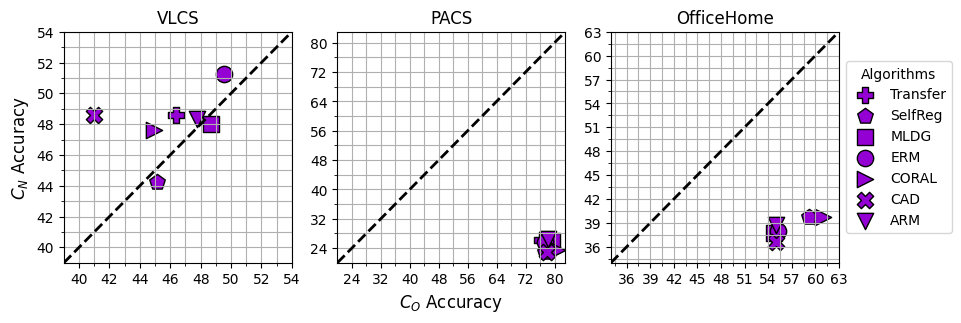

In [35]:
from results import plot_dataset, AXIS_LABELS

dataset_list = list(df['dataset'].unique())
x='oacc'
y='nacc'
color_metric='acc'

for selec_metric in ['nacc']:
    fig, ax = plt.subplots(
        nrows=1, ncols=len(dataset_list), figsize=(10,3), sharey=False)

    for i, dataset in enumerate(dataset_list):
        last_ax = plot_dataset(
            df=df, 
            ax=ax[i], 
            selec_metric=selec_metric,
            dataset=dataset,
            x=x,
            y=y,
            color_metric=color_metric)

    # LABELS
    ax[0].set_ylabel(AXIS_LABELS[y], fontsize=12)
    ax[1].set_xlabel(AXIS_LABELS[x], fontsize=12)
    # LEGEND
    ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Algorithms")

## Create a scatter plot for each dataset for each overlap
- Also visualizes the effect of different selection metrics

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/2313535207.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_88186/2313535207.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


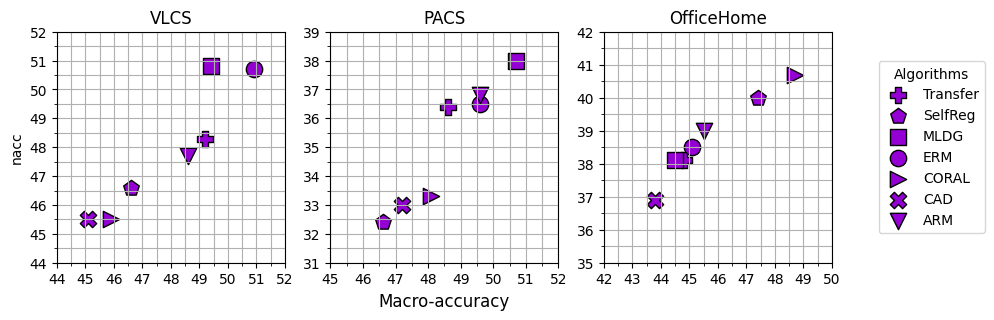

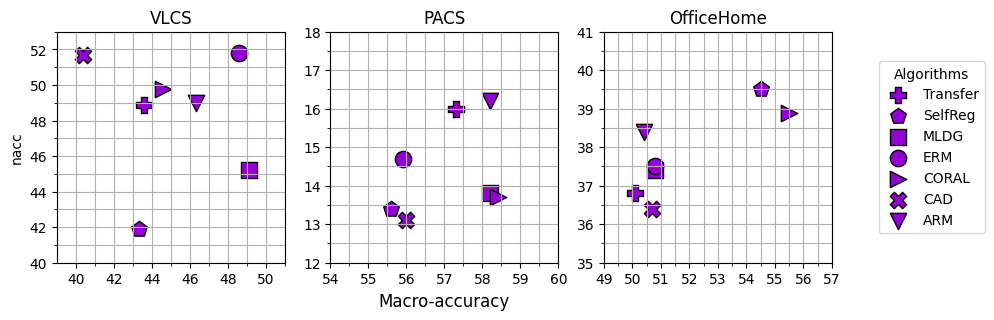

In [15]:
dataset_list = list(df['dataset'].unique())
x='macc'
y='nacc'
color_metric='acc'
selec_metric='nacc'

for overlap in ['33', '66']:
    fig, ax = plt.subplots(
        nrows=1, ncols=len(dataset_list), figsize=(10,3), sharey=False)

    for i, dataset in enumerate(dataset_list):
        last_ax = plot_dataset(
            df, 
            dataset, 
            ax[i], 
            selec_metric=selec_metric,
            x=x,
            y=y,
            color_metric=color_metric,
            overlap=overlap)

    ax[0].set_ylabel(y)
    # LEGEND
    ax[-1].legend(loc='center right', bbox_to_anchor=(1.7, 0.5), title="Algorithms")
    ax[1].set_xlabel(AXIS_LABELS[x], fontsize=12)

    fig.show()